In [186]:
from backpack_predictor import prepare_data, target_encoding
from backpack_predictor.features import target, baseline_features, feature_list, cat_cols

%load_ext autoreload
%autoreload 2

from datetime import datetime
import time
import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import KBinsDiscretizer, TargetEncoder
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

test_df = pd.read_csv(r'..//data//test.csv')
train_df = pd.read_csv(r'..//data//train.csv')
# train_extra_df = pd.read_csv(r'..//data//training_extra.csv')
# train_df = pd.concat([train_df, train_extra_df], ignore_index=True)

def prepare_data(df: pd.DataFrame, is_train: bool = True):
    """
    Prepares the dataset for training or testing by renaming columns, handling missing values,
    converting categorical and numerical features, and creating new features.
    
    Args:
        df (pd.DataFrame): The input dataframe (train or test).
        is_train (bool): Indicates if the dataframe is training data (default is True).
        
    Returns:
        pd.DataFrame: The processed dataframe.
    """
    
    # Define the column names
    columns = [
        'id', 'brand', 'material', 'size', 'compartments', 
        'laptop_compartment', 'is_waterproof', 'style', 'color', 
        'weight_capacity'
    ]
    
    if is_train:
        columns.append('price')
    
    df.columns = columns
    
    # if is_train:
    #     df = df.drop(columns='id')
    
    # Define the mapping for Size conversion
    size_mapping = {"Small": 0, "Medium": 1, "Large": 2}
    df["size"] = df["size"].map(size_mapping).fillna(-1)
    df["size"] = df["size"].astype(int)
    
    # Handle weight capacity
    df['weight_capacity'] = df['weight_capacity'].fillna(0)
    # df['weight_capacity_int'] = df['weight_capacity'].astype(int)
    # df['weight_capacity_size'] = df['weight_capacity'] * df['size_int']
    
    # Convert categorical columns
    df['compartments'] = df['compartments'].astype(int)
    df['compartments'] = df['compartments'].astype('category')
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    df[cat_cols] = df[cat_cols].astype('category')
    
    # Convert boolean columns to integer type
    df['laptop_compartment'] = df['laptop_compartment'].cat.codes.fillna(-1).astype(int)
    df['is_waterproof'] = df['is_waterproof'].cat.codes.fillna(-1).astype(int)
    
    return df


# Apply function to train and test datasets
train_df = prepare_data(train_df, is_train=True)
test_df = prepare_data(test_df, is_train=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [187]:
# Add noise as a baseline
rng = np.random.default_rng(seed=44)
n_rows = len(train_df)

train_df['rng_bin'] = rng.binomial(n=1, p=0.5, size=n_rows)
train_df['rng_uniform'] = rng.uniform(low=0, high=100, size=n_rows)
train_df['rng_normal'] = rng.normal(loc=1, scale=10, size=n_rows)

In [160]:
train_df

,id,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,...,weight_capacity_decimal_3,weight_capacity_decimal_4,weight_capacity_decimal_5,weight_capacity_decimal_6,rng_normal_decimal_1,rng_normal_decimal_2,rng_normal_decimal_3,rng_normal_decimal_4,rng_normal_decimal_5,rng_normal_decimal_6
0,0,Jansport,Leather,1,7,1,0,Tote,Black,11.611723,...,1,7,2,2,5,9,2,7,3,0
1,1,Jansport,Canvas,0,10,1,1,Messenger,Green,27.078537,...,8,5,3,6,9,5,4,3,6,7
2,2,Under Armour,Leather,0,2,1,0,Messenger,Red,16.643760,...,3,7,5,9,0,5,0,3,5,9
3,3,Nike,Nylon,0,8,1,0,Messenger,Green,12.937220,...,7,2,2,0,9,8,6,0,8,2
4,4,Adidas,Canvas,1,1,1,1,Messenger,Green,17.749338,...,9,3,3,8,3,1,0,2,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,0,9,0,0,Tote,Blue,12.730812,...,0,8,1,1,9,1,2,1,0,1
299996,299996,Jansport,Leather,2,6,0,1,Tote,Blue,26.633182,...,3,1,8,2,2,7,0,5,8,8
299997,299997,Puma,Canvas,2,9,1,1,Backpack,Pink,11.898250,...,8,2,4,9,4,0,0,6,4,6
299998,299998,Adidas,Nylon,0,1,0,1,Tote,Pink,6.175738,...,5,7,3,7,6,3,7,4,8,8


,price,id
0,15.0,693
1,148.0,5
2,150.0,5528


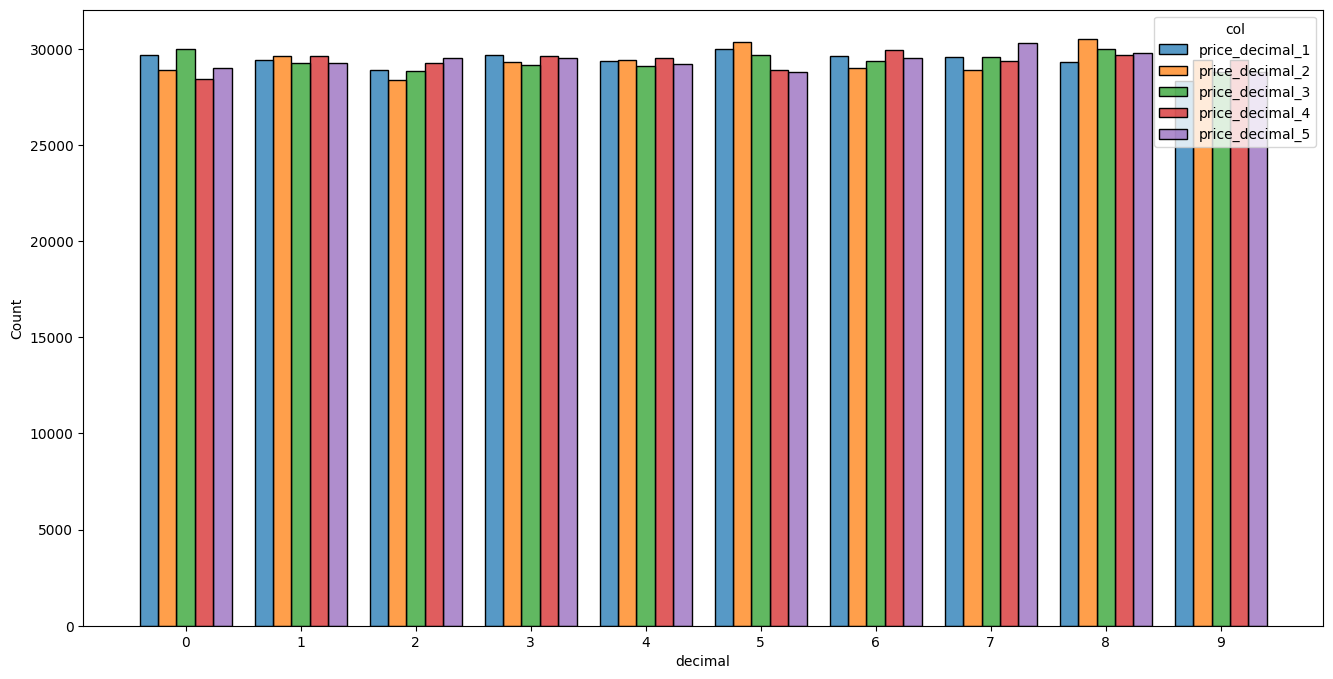

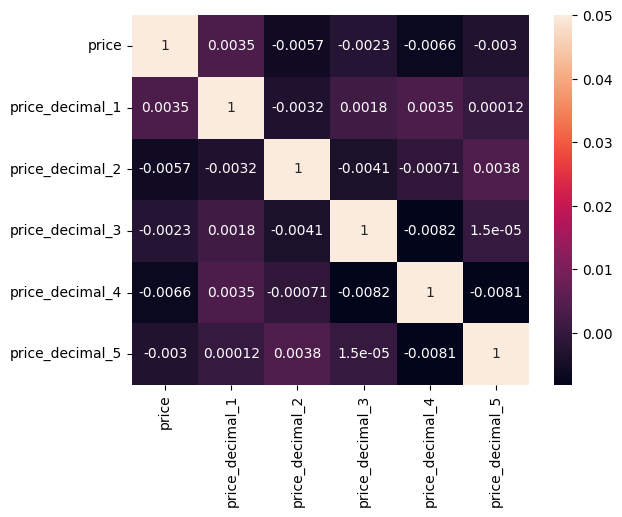

chi2_stat: 117.10539394228218,
p_value: 5.2232649693939665e-21


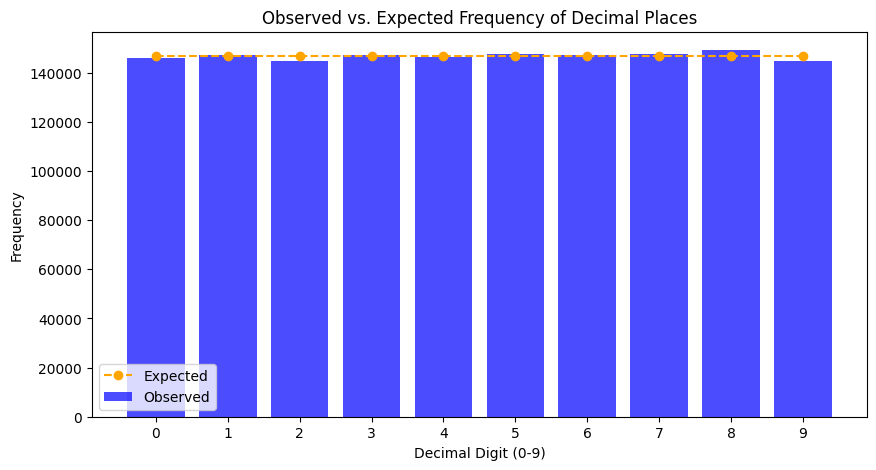

,Deviation (%)
0,-0.593654
1,0.171560
2,-1.384057
3,0.242363
4,-0.157264
5,0.560975
6,0.398265
7,0.570507
8,1.640717
9,-1.449413


,weight_capacity,id
0,0.0,138
1,5.0,4286
2,30.0,185


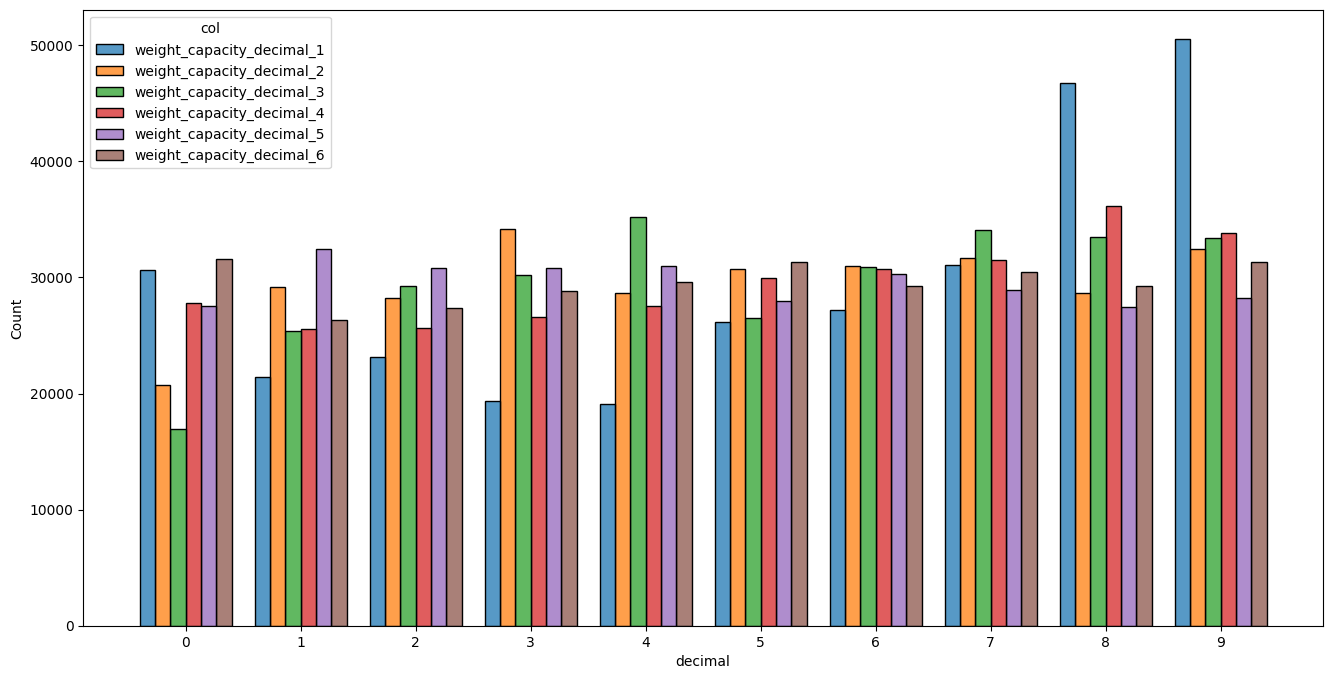

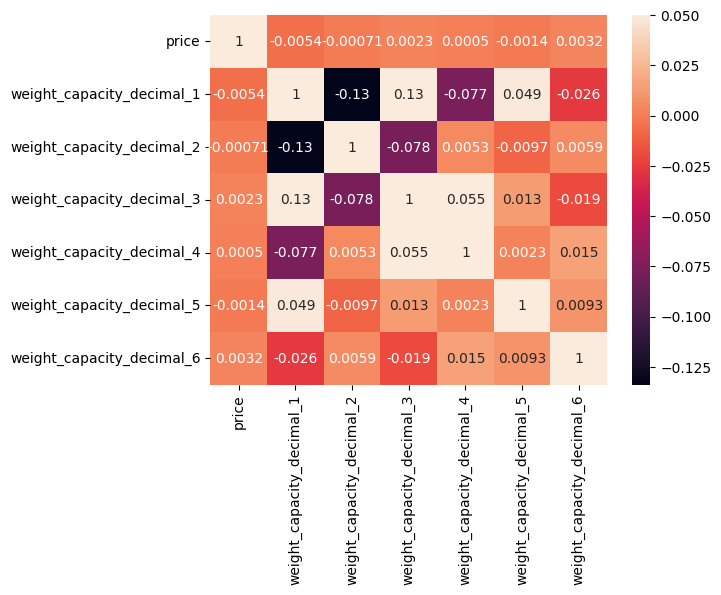

chi2_stat: 15857.707007548186,
p_value: 0.0


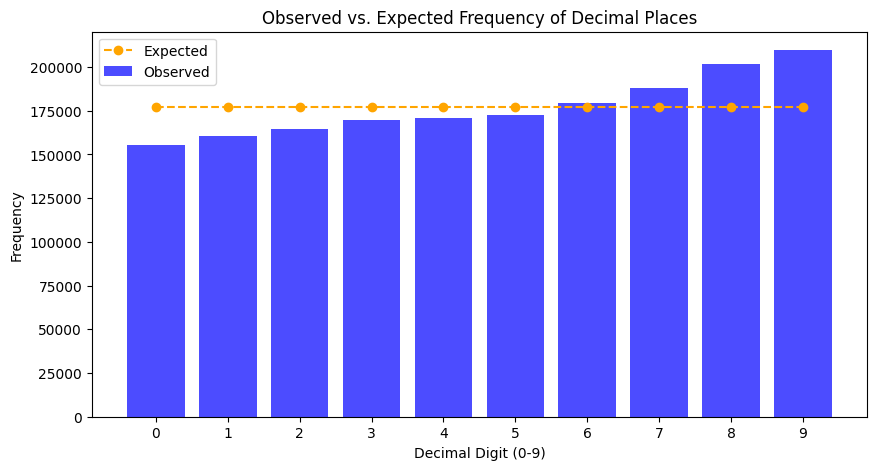

,Deviation (%)
0,-12.370384
1,-9.536851
2,-7.217327
3,-4.102246
4,-3.490063
5,-2.595204
6,1.244904
7,5.948274
8,13.803964
9,18.314934


,rng_normal,id


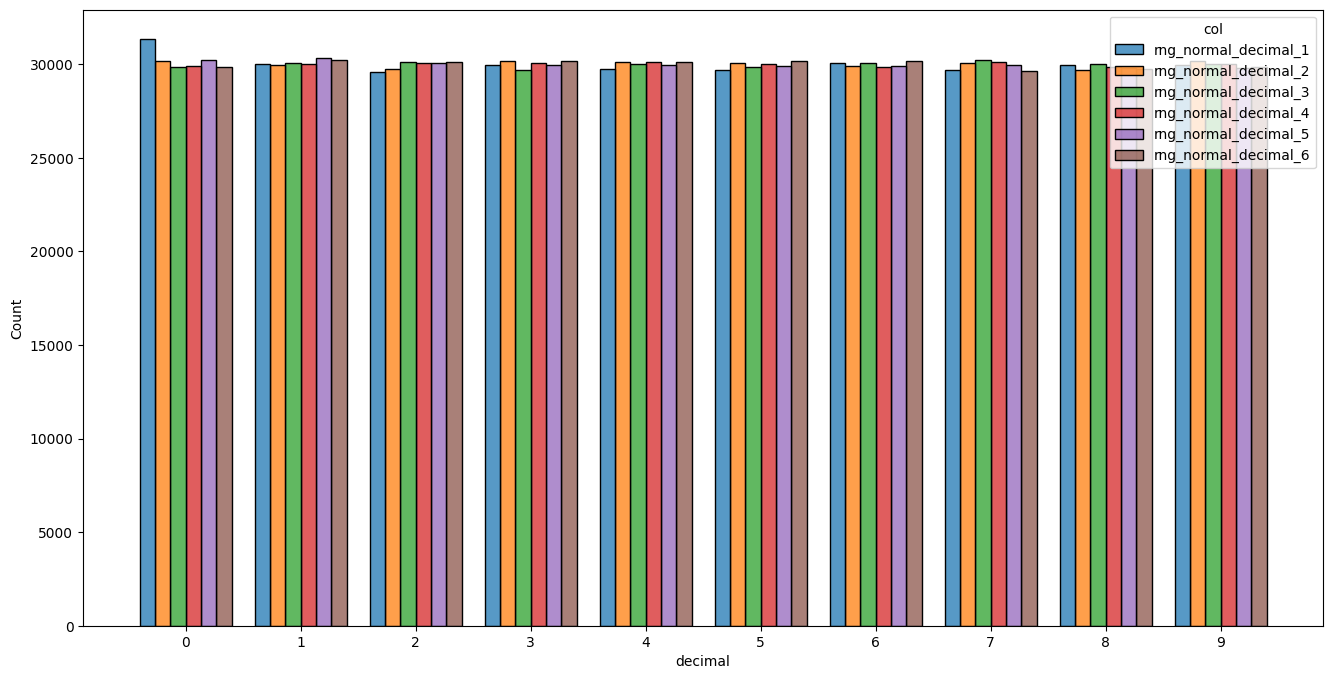

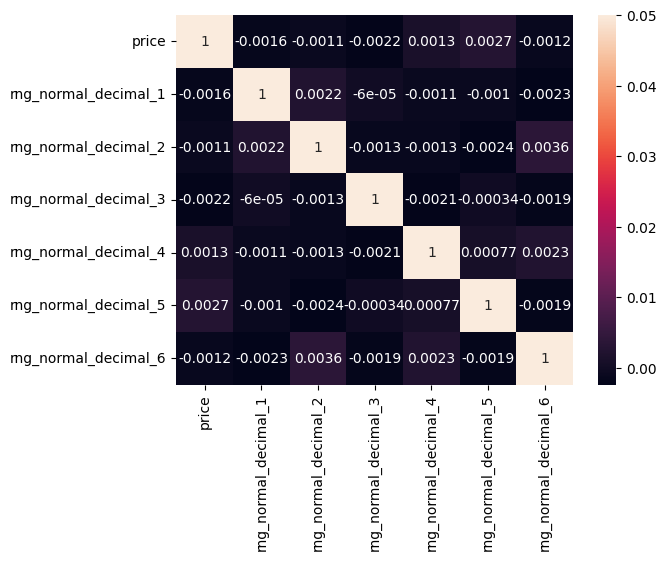

chi2_stat: 18.926211111111108,
p_value: 0.02582766691717993


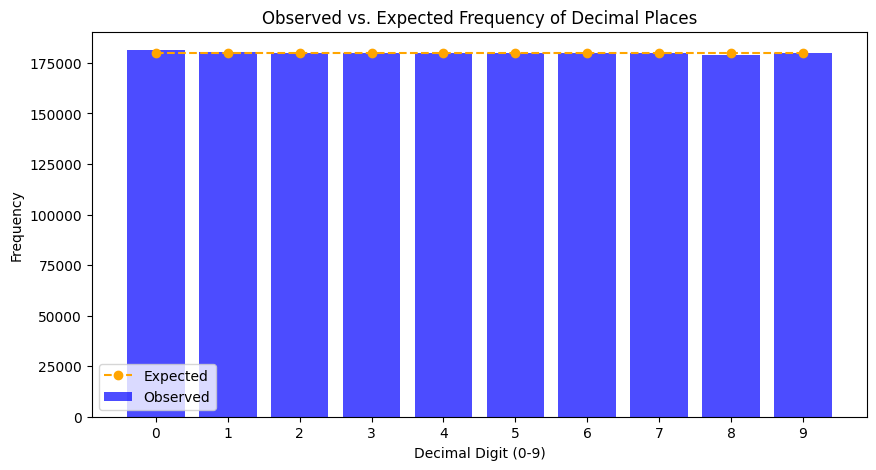

,Deviation (%)
0,0.746111
1,0.341111
2,-0.151667
3,0.015556
4,0.027778
5,-0.169444
6,0.002778
7,-0.146667
8,-0.536111
9,-0.129444


In [ ]:
def analyze_decimals(train_df, num_col='weight_capacity', precision=7):
    dec_cols = []
    for n in range(1, precision):
        new_col = f"{num_col}_decimal_{n}"
        train_df[new_col] = (train_df[num_col] * 10**n).astype(int) % 10
        dec_cols.append(new_col)

    not_even = train_df[train_df[num_col] != train_df[num_col].round(0)]
    even = train_df[train_df[num_col] == train_df[num_col].round(0)]
    rounded_counts = (
        even.groupby(num_col, as_index=False)['id'].count()
    )
    print("Count of rows where the value has no decimal places.")
    display(rounded_counts)

    combined = []
    for col in dec_cols:
        combined.append(
            pd.DataFrame({
                "decimal": not_even[col], 
                'col': col})
        )
    combined = pd.concat(combined)

    # conver to string for plotting
    combined['decimal'] = combined['decimal'].astype(str)
    plt.figure(figsize=(16,8))
    sns.histplot(combined.sort_values(by=['decimal', 'col']), x='decimal', hue='col', multiple="dodge", shrink=0.8)
    plt.show()

    sns.heatmap(not_even[['price']+dec_cols].corr(), vmax=.05, annot=True)
    plt.show()


    # Expected frequencies assuming a uniform distribution (equal probability for each digit)
    observed_frequencies = combined.groupby('decimal').count().to_numpy().reshape(-1)
    # print(observed_frequencies)
    # return observed_frequencies
    expected_frequency = observed_frequencies.sum() / len(observed_frequencies)
    expected_frequencies = np.full_like(observed_frequencies, expected_frequency, dtype=np.float64)
    # expected_frequency = np.mean(observed_frequencies)
    # expected_frequencies = np.full_like(observed_frequencies, expected_frequency)
    chi2_stat, p_value = stats.chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)
    print(f"chi2_stat: {chi2_stat},\np_value: {p_value}")

    decimals = np.arange(10)
    df = pd.DataFrame({"Decimal": decimals, "Observed": observed_frequencies, "Expected": expected_frequencies})

    # Plot observed vs expected frequencies
    plt.figure(figsize=(10, 5))
    plt.bar(df["Decimal"], df["Observed"], alpha=0.7, label="Observed", color='b')
    plt.plot(df["Decimal"], df["Expected"], marker='o', linestyle='dashed', color='#FFA500', label="Expected")

    plt.xlabel("Decimal Digit (0-9)")
    plt.ylabel("Frequency")
    plt.title("Observed vs. Expected Frequency of Decimal Places")
    plt.xticks(decimals)
    plt.legend()
    plt.show()

    # Checking deviation by computing percentage differences
    df["Deviation (%)"] = ((df["Observed"] - df["Expected"]) / df["Expected"]) * 100
    display(df[["Deviation (%)"]])

analyze_decimals(train_df, num_col='price', precision=6)
analyze_decimals(train_df, num_col='weight_capacity', precision=7)
analyze_decimals(train_df, num_col='rng_normal', precision=7)

,weight_capacity,id
0,0.0,138
1,5.0,4286
2,30.0,185


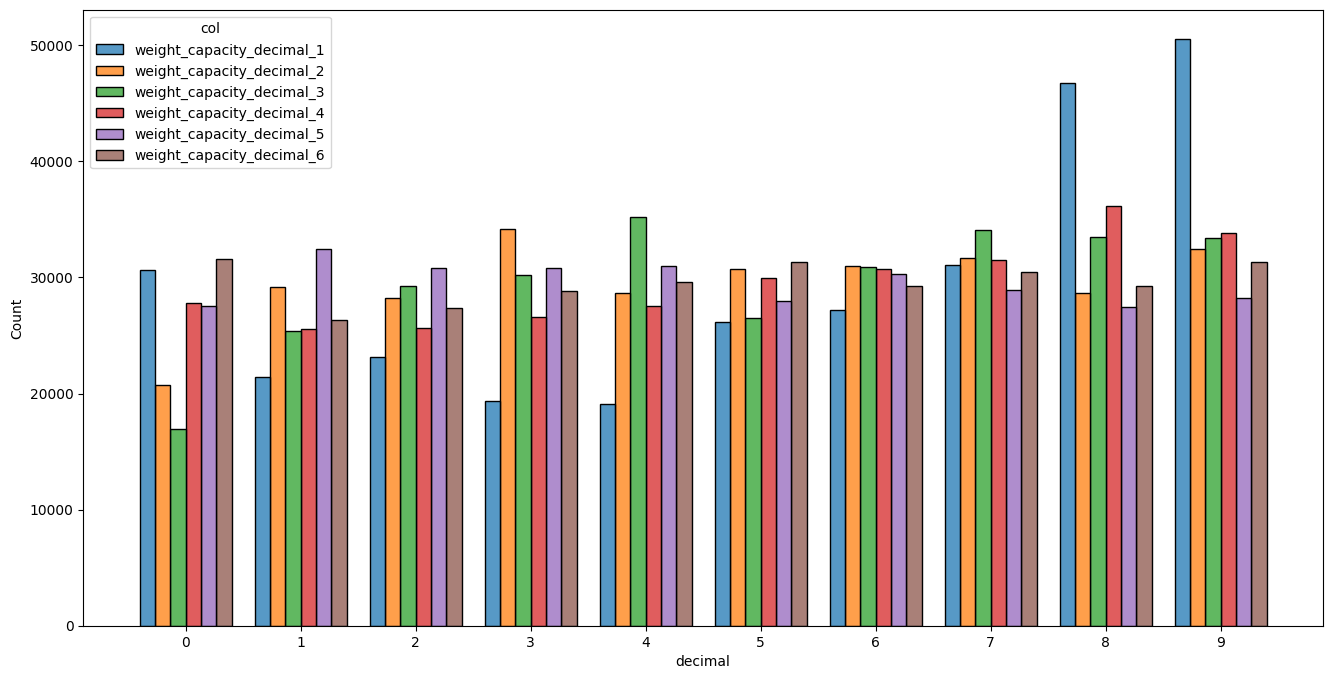

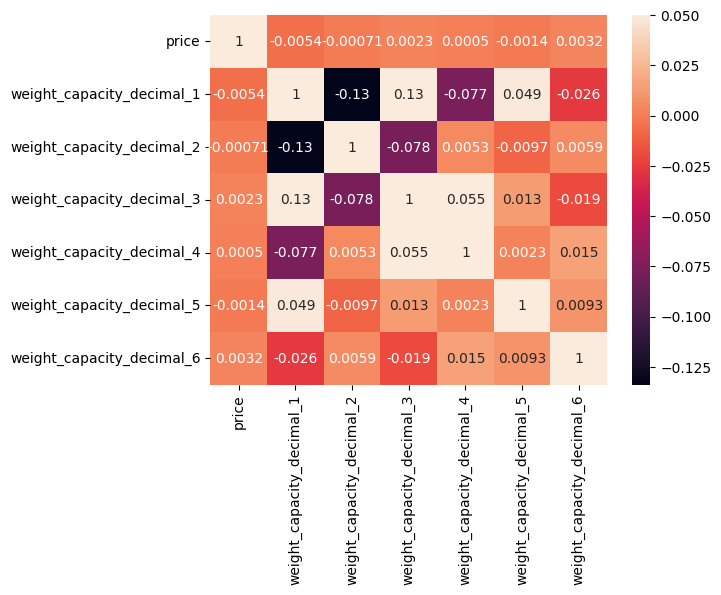

array([155310, 160332, 164443, 169964, 171049, 172635, 179441, 187777,
       201700, 209695])

In [198]:
# freq = analyze_decimals(train_df, num_col='price', precision=6)
freq = analyze_decimals(train_df, num_col='weight_capacity', precision=7)
freq

In [200]:
freq.sum()

np.int64(1772346)

In [201]:
expected_frequency

np.float64(177234.6)

In [203]:
expected_frequencies.sum()

np.int64(1772340)

In [ ]:
expected_frequency = np.mean(freq)
# expected_frequencies = np.round(np.full_like(freq, freq.sum() / len(freq))).astype(int)
# expected_frequencies = np.full_like(freq, expected_frequency)
# Due to rounding, there may still be a slight discrepancy, so 
# expected_frequencies[-1] += freq.sum() - expected_frequencies.sum()
expected_frequency = freq.sum() / len(freq)  # Ensures sum matches exactly
expected_frequencies = np.full_like(freq, expected_frequency, dtype=np.float64)
chi2_stat, p_value = stats.chisquare(f_obs=freq, f_exp=expected_frequencies)
chi2_stat, p_value

(np.float64(15857.707007548186), np.float64(0.0))

In [211]:
expected_frequencies

array([177234.6, 177234.6, 177234.6, 177234.6, 177234.6, 177234.6,
       177234.6, 177234.6, 177234.6, 177234.6])

In [206]:
expected_frequencies

array([177234, 177234, 177234, 177234, 177234, 177234, 177234, 177234,
       177234, 177240])

In [114]:
num_col = 'weight_capacity'
for n in range(1, 7):
    train_df[f"{num_col}_decimal_{n}"] = (train_df[num_col] * 10**n).astype(int) % 10

train_df[train_df[num_col] == train_df[num_col].round(0)].groupby(num_col, as_index=False)['id'].count()

,weight_capacity,id
0,0.0,138
1,5.0,4286
2,30.0,185


<Axes: xlabel='decimal', ylabel='Count'>

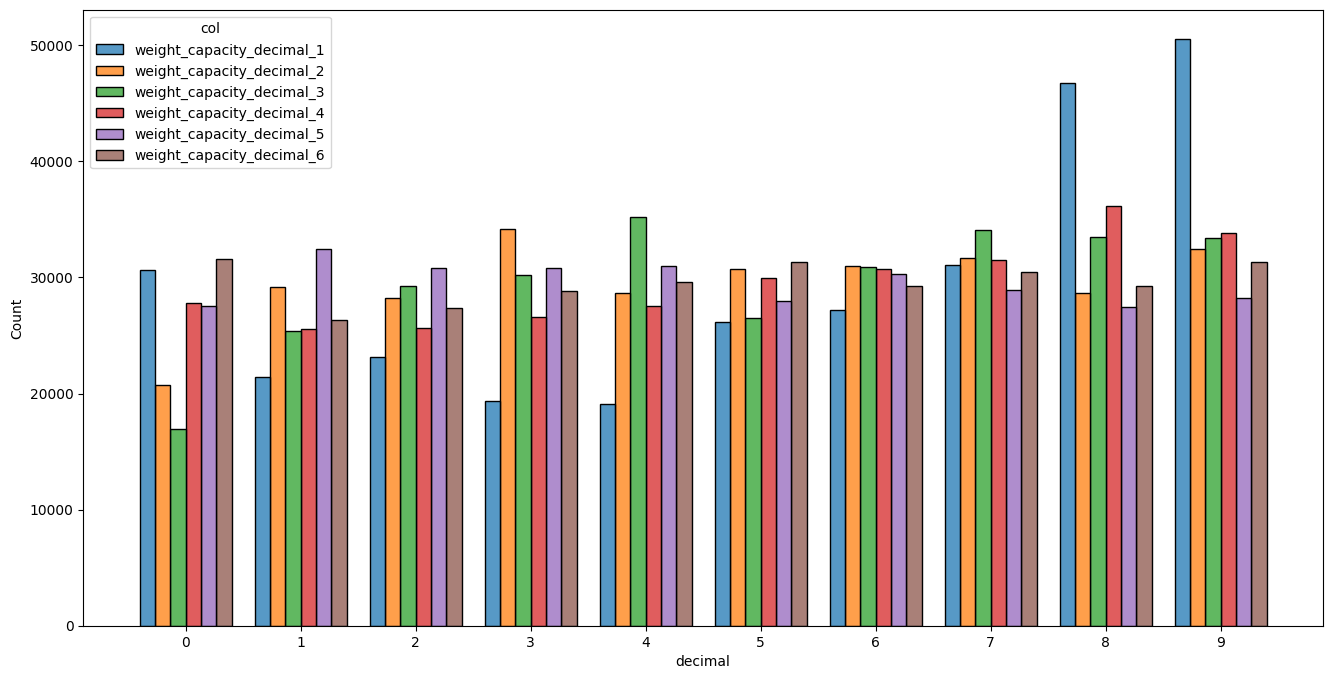

In [131]:
dec_cols = [f"{num_col}_decimal_{n}" for n in range(1, 7)]

not_even = train_df[train_df[num_col] != train_df[num_col].round(0)]
combined = []

for col in dec_cols:
    combined.append(
        pd.DataFrame({
            "decimal": not_even[col], 
            'col': col})
    )
    
combined = pd.concat(combined)

combined['decimal'] = combined['decimal'].astype(str)

plt.figure(figsize=(16,8))
sns.histplot(combined.sort_values(by=['decimal', 'col']), x='decimal', hue='col', multiple="dodge", shrink=0.8)

<Axes: >

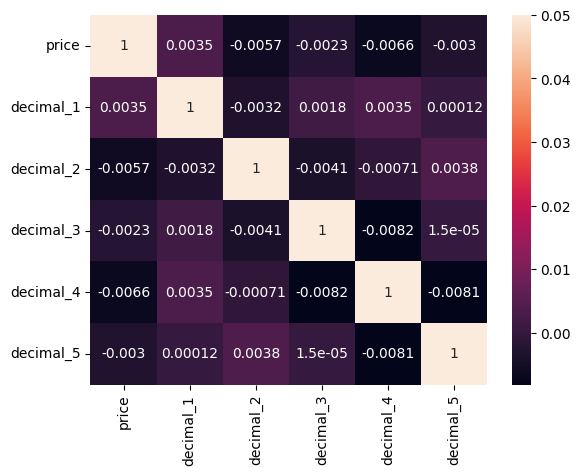

In [ ]:
# not_even[['price', 'weight_capacity_decimal_1']].corr()
sns.heatmap(not_even[['price']+dec_cols].corr(), vmax=.05, annot=True)


In [136]:
train_df

,id,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,...,decimal_2,decimal_3,decimal_4,decimal_5,weight_capacity_decimal_1,weight_capacity_decimal_2,weight_capacity_decimal_3,weight_capacity_decimal_4,weight_capacity_decimal_5,weight_capacity_decimal_6
0,0,Jansport,Leather,1,7,1,0,Tote,Black,11.611723,...,5,8,7,5,6,1,1,7,2,2
1,1,Jansport,Canvas,0,10,1,1,Messenger,Green,27.078537,...,8,0,5,6,0,7,8,5,3,6
2,2,Under Armour,Leather,0,2,1,0,Messenger,Red,16.643760,...,7,3,2,0,6,4,3,7,5,9
3,3,Nike,Nylon,0,8,1,0,Messenger,Green,12.937220,...,0,7,9,3,9,3,7,2,2,0
4,4,Adidas,Canvas,1,1,1,1,Messenger,Green,17.749338,...,2,3,1,2,7,4,9,3,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,0,9,0,0,Tote,Blue,12.730812,...,9,7,4,9,7,3,0,8,1,1
299996,299996,Jansport,Leather,2,6,0,1,Tote,Blue,26.633182,...,5,8,1,9,6,3,3,1,8,2
299997,299997,Puma,Canvas,2,9,1,1,Backpack,Pink,11.898250,...,1,3,6,4,8,9,8,2,4,9
299998,299998,Adidas,Nylon,0,1,0,1,Tote,Pink,6.175738,...,9,0,8,0,1,7,5,7,3,7


In [132]:
for n in range(1, 6):
    train_df[f"decimal_{n}"] = (train_df["price"] * 10**n).astype(int) % 10
train_df

,id,brand,material,size,compartments,laptop_compartment,is_waterproof,style,color,weight_capacity,...,decimal_2,decimal_3,decimal_4,decimal_5,weight_capacity_decimal_1,weight_capacity_decimal_2,weight_capacity_decimal_3,weight_capacity_decimal_4,weight_capacity_decimal_5,weight_capacity_decimal_6
0,0,Jansport,Leather,1,7,1,0,Tote,Black,11.611723,...,5,8,7,5,6,1,1,7,2,2
1,1,Jansport,Canvas,0,10,1,1,Messenger,Green,27.078537,...,8,0,5,6,0,7,8,5,3,6
2,2,Under Armour,Leather,0,2,1,0,Messenger,Red,16.643760,...,7,3,2,0,6,4,3,7,5,9
3,3,Nike,Nylon,0,8,1,0,Messenger,Green,12.937220,...,0,7,9,3,9,3,7,2,2,0
4,4,Adidas,Canvas,1,1,1,1,Messenger,Green,17.749338,...,2,3,1,2,7,4,9,3,3,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,299995,Adidas,Leather,0,9,0,0,Tote,Blue,12.730812,...,9,7,4,9,7,3,0,8,1,1
299996,299996,Jansport,Leather,2,6,0,1,Tote,Blue,26.633182,...,5,8,1,9,6,3,3,1,8,2
299997,299997,Puma,Canvas,2,9,1,1,Backpack,Pink,11.898250,...,1,3,6,4,8,9,8,2,4,9
299998,299998,Adidas,Nylon,0,1,0,1,Tote,Pink,6.175738,...,9,0,8,0,1,7,5,7,3,7


In [133]:
train_df[train_df['price'] == train_df['price'].round(0)].groupby('price', as_index=False)['id'].count()

,price,id
0,15.0,693
1,148.0,5
2,150.0,5528


In [134]:
dec_cols = [f"decimal_{n}" for n in range(1, 6)]

not_even = train_df[train_df['price'] != train_df['price'].round(0)]
combined = []

for col in dec_cols:
    combined.append(
        pd.DataFrame({
            "decimal": not_even[col], 
            'col': col})
    )
    # sns.histplot(not_even[col])
    # plt.show()

combined = pd.concat(combined)

In [100]:
combined

,decimal,col
0,1,decimal_1
1,8,decimal_1
2,1,decimal_1
3,6,decimal_1
4,0,decimal_1
...,...,...
299995,9,decimal_5
299996,9,decimal_5
299997,4,decimal_5
299998,0,decimal_5


In [102]:
combined.groupby('decimal').count()

,col
decimal,
0,146015
1,147139
2,144854
3,147243
4,146656
5,147711
6,147472
7,147725
8,149297


<Axes: xlabel='decimal', ylabel='Count'>

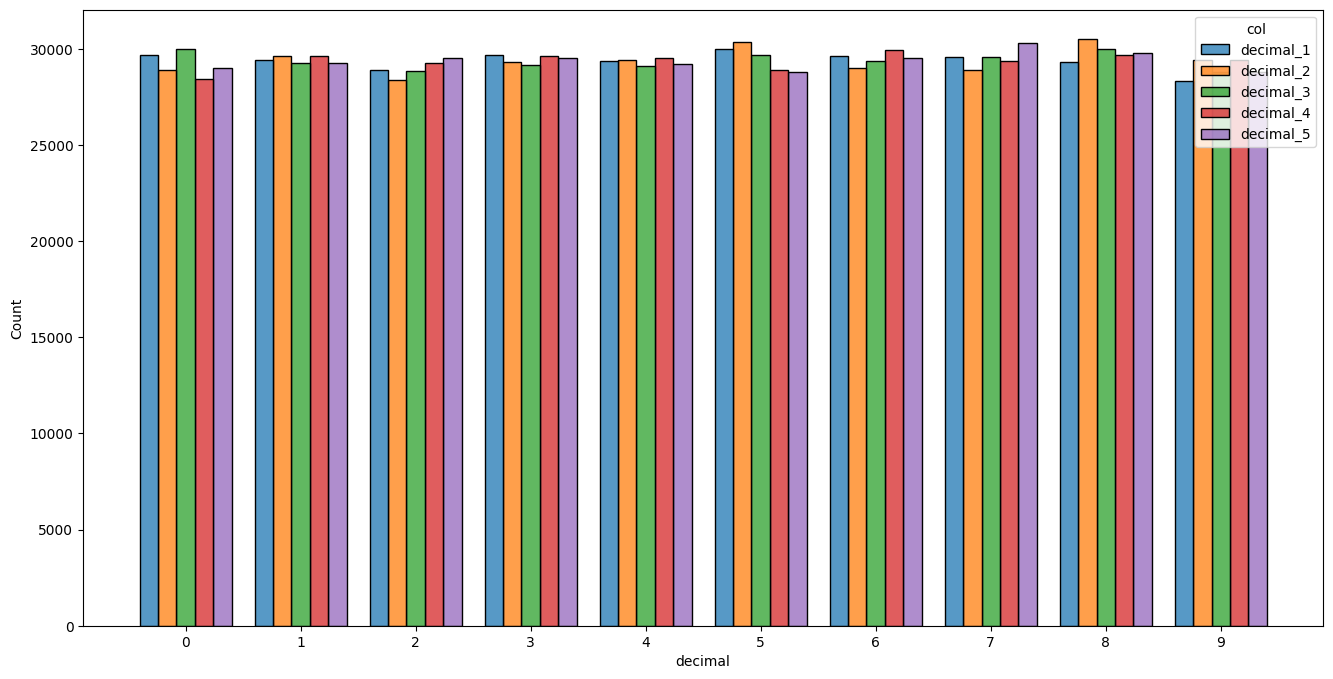

In [135]:
combined['decimal'] = combined['decimal'].astype(str)

plt.figure(figsize=(16,8))
sns.histplot(combined.sort_values(by=['decimal', 'col']), x='decimal', hue='col', multiple="dodge", shrink=0.8)

chi2_stat: 117.10539394228218,
p_value: 5.2232649693939665e-21


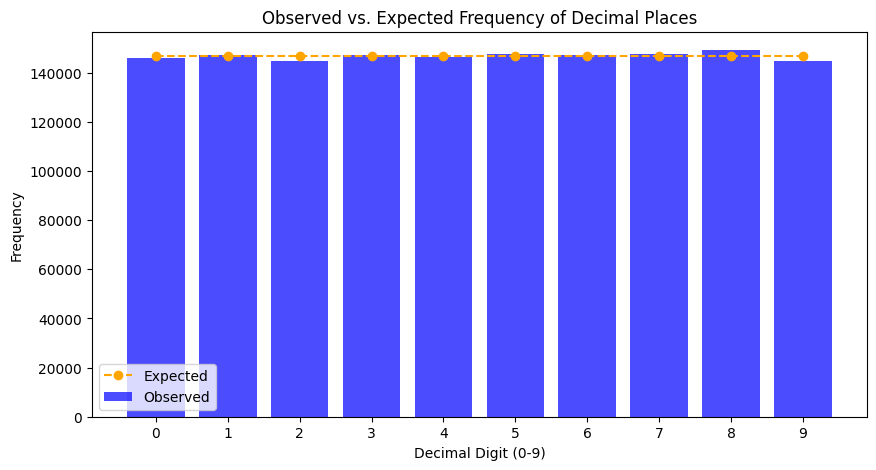

,Deviation (%)
0,-0.593654
1,0.171560
2,-1.384057
3,0.242363
4,-0.157264
5,0.560975
6,0.398265
7,0.570507
8,1.640717
9,-1.449413


In [ ]:
# Observed frequencies (from the provided data)
observed_frequencies = np.array([
    146015, 147139, 144854, 147243, 146656,
    147711, 147472, 147725, 149297, 144758
])

# Expected frequencies assuming a uniform distribution (equal probability for each digit)
expected_frequency = np.mean(observed_frequencies)  # Mean of observed counts
expected_frequencies = np.full_like(observed_frequencies, expected_frequency)

# Perform Chi-Square Goodness-of-Fit test
chi2_stat, p_value = stats.chisquare(f_obs=observed_frequencies, f_exp=expected_frequencies)

# Output results
chi2_stat, p_value

(np.float64(117.10539394228218), np.float64(5.2232649693939665e-21))

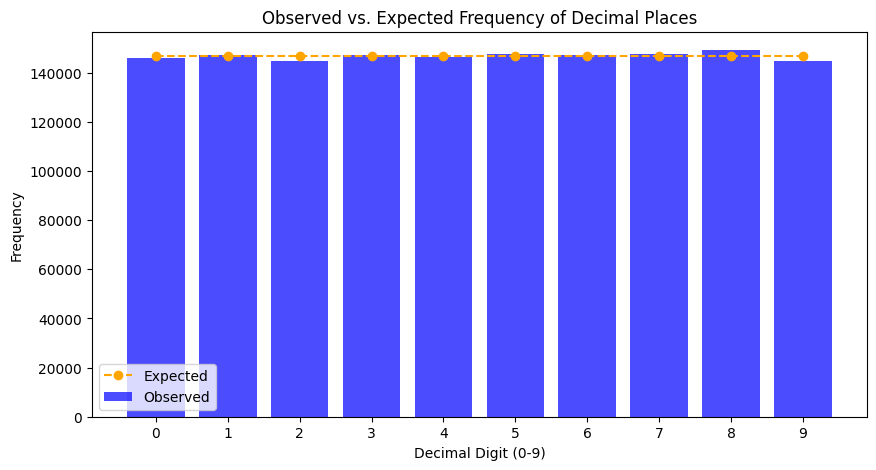

In [ ]:
decimals = np.arange(10)
df = pd.DataFrame({"Decimal": decimals, "Observed": observed_frequencies, "Expected": expected_frequencies})

# Plot observed vs expected frequencies
plt.figure(figsize=(10, 5))
plt.bar(df["Decimal"], df["Observed"], alpha=0.7, label="Observed", color='b')
plt.plot(df["Decimal"], df["Expected"], marker='o', linestyle='dashed', color='#FFA500', label="Expected")

plt.xlabel("Decimal Digit (0-9)")
plt.ylabel("Frequency")
plt.title("Observed vs. Expected Frequency of Decimal Places")
plt.xticks(decimals)
plt.legend()
plt.show()

# Checking deviation by computing percentage differences
df["Deviation (%)"] = ((df["Observed"] - df["Expected"]) / df["Expected"]) * 100


In [109]:
price_bins

array([144758. , 145782.8, 146945.8, 147334.6, 147713.8, 149297. ])

,Price_Range,Observed
0,Bin 1,289612
1,Bin 2,292671
2,Bin 3,294382
3,Bin 4,295183
4,Bin 5,297022


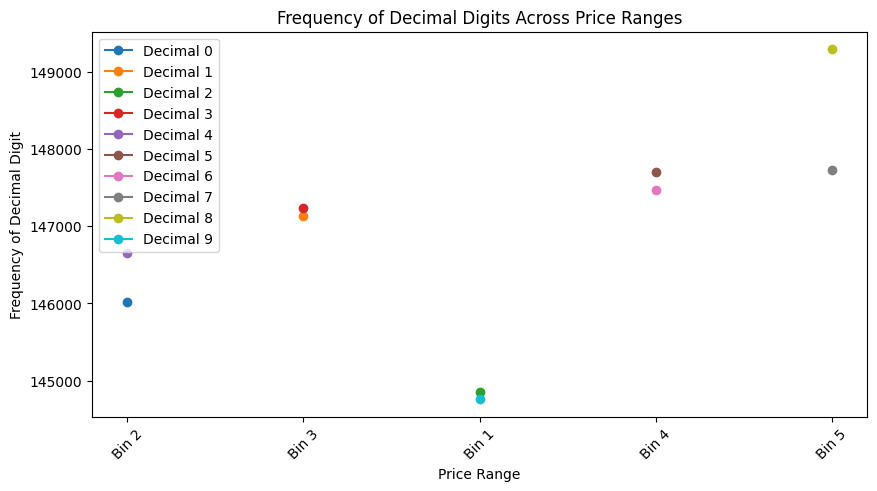

In [ ]:
# Investigating decimal place distribution across different price ranges

# Creating synthetic price ranges based on percentiles
price_bins = np.percentile(observed_frequencies, np.linspace(0, 100, 6))  # 5 bins
bin_labels = [f"Bin {i+1}" for i in range(len(price_bins) - 1)]
decimal_price_df = pd.DataFrame({
    "Price_Range": pd.cut(observed_frequencies, bins=price_bins, labels=bin_labels, include_lowest=True),
    "Decimal": decimals,
    "Observed": observed_frequencies
})

# Group by price range to see decimal frequency variations
price_range_distribution = decimal_price_df.groupby("Price_Range")["Observed"].sum()

# Displaying the price range distribution
display(price_range_distribution.reset_index())

# Checking if certain decimal digits are more common in specific price ranges
plt.figure(figsize=(10, 5))
for decimal in decimals:
    subset = decimal_price_df[decimal_price_df["Decimal"] == decimal]
    plt.plot(subset["Price_Range"], subset["Observed"], marker='o', linestyle='-', label=f"Decimal {decimal}")

plt.xlabel("Price Range")
plt.ylabel("Frequency of Decimal Digit")
plt.title("Frequency of Decimal Digits Across Price Ranges")
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [81]:
train_df[[f"decimal_{n}" for n in range(1, 6)]]

,decimal_1,decimal_2,decimal_3,decimal_4,decimal_5
0,1,5,8,7,5
1,8,8,0,5,6
2,1,7,3,2,0
3,6,0,7,9,3
4,0,2,3,1,2
...,...,...,...,...,...
299995,9,9,7,4,9
299996,8,5,8,1,9
299997,4,1,3,6,4
299998,8,9,0,8,0


In [60]:
train_df[['rng_bin', 'price']].corr('spearman')

,rng_bin,price
rng_bin,1.00000,-0.00233
price,-0.00233,1.00000


In [61]:
id_mod_cols = []
for n in range(1, 5):
    col = f'id_mod_{n}'
    id_mod_cols.append(col)
    train_df[col] = train_df['id'] % n

In [62]:
for feature in ['weight_capacity', 'id', 'rng_bin', 'rng_uniform', 'rng_normal'] + id_mod_cols:
    print("\n", feature, "________________________")
    print(f"{train_df[[feature, 'price']].corr().loc["price", feature].item():.5f}")
    print(f"{train_df[[feature, 'price']].corr('spearman').loc["price", feature].item():.5f}")


 weight_capacity ________________________
0.01856
0.01787

 id ________________________
0.00203
0.00195

 rng_bin ________________________
-0.00237
-0.00233

 rng_uniform ________________________
0.00061
0.00061

 rng_normal ________________________
0.00253
0.00174

 id_mod_1 ________________________
nan
nan

 id_mod_2 ________________________
-0.00059
-0.00058

 id_mod_3 ________________________
-0.00153
-0.00149

 id_mod_4 ________________________
0.00208
0.00205


In [72]:
id_mod_cols = []
for n in range(2, 10000):
    col = f'id_mod_{n}'
    id_mod_cols.append(col)
    train_df[col] = train_df['id'] % n
    corr = train_df[[col, 'price']].corr().loc["price", col].item()
    if (corr > 0.02 and corr > 0) or (corr < 0 and corr < -0.02):
        print(col, corr)

In [70]:
for n in range(2, 10):
    col = f'weight_capacity_{n}'
    train_df[col] = train_df['weight_capacity'] % n
    corr = train_df[[col, 'price']].corr().loc["price", col].item()
    # print(col, corr)
    if (corr > 0.02 and corr > 0) or (corr < 0 and corr < -0.02):
        print(col, corr)

In [6]:
train_df[['id', 'price']].corr()

,id,price
id,1.00000,-0.00067
price,-0.00067,1.00000


In [8]:
train_df[['id', 'price']].corr('spearman')

,id,price
id,1.000000,-0.000656
price,-0.000656,1.000000
